<a href="https://colab.research.google.com/github/VonageGarage/AnsweringMachineDetection/blob/master/AMD_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import os

In [22]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
RECORDINGS_PATH = "/content/drive/My Drive/amd-training"
os.chdir(RECORDINGS_PATH)
df = pd.read_pickle("amd-model-40-200-mfccs-kaiser_fast.pkl")

#combine answering-machine and beeps to 'beep'
df['label'] = df['label'].apply(lambda x: "beep" if x == "answering-machine" or x == "beeps" else "speech")

#convert label seriers to ints
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['label'])
df['label'] = le.transform(df['label']) 

print("count:")
print(df.label.value_counts())
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)
class_names = le.classes_

df.head()


count:
1    344
0    135
Name: label, dtype: int64
{'beep': 0, 'speech': 1}


,file_path,mfccs_40,mfccs_200,chroma,mel,contrast,tonnetz,duration,label
0,beeps/jZYhDjf-pOg.wav,"[-175.15851073092304, 94.64503179949635, -2.72...","[-175.15851073092304, 94.64503179949635, -2.72...","[0.7899764590759345, 0.7388955567463658, 0.731...","[15.680954948980553, 41.94055362585754, 45.182...","[15.15379137037688, 12.150320617633616, 14.416...","[0.009020952013215183, 0.006404506696848954, 0...",20.000000,0
1,beeps/wECGYE_1TGU.wav,"[-164.2874903781957, 104.86712628440044, -0.23...","[-164.2874903781957, 104.86712628440044, -0.23...","[0.530812638145738, 0.5918595112930464, 0.6468...","[0.17906365761524, 0.14166714141119982, 0.1689...","[18.07812746151239, 14.580879182793254, 16.852...","[0.004358848026502088, -0.0025256492772747718,...",40.000000,0
2,beeps/9O2Keu6o3i0.wav,"[-136.95742281516291, 91.71129077232968, -20.1...","[-136.95742281516291, 91.71129077232968, -20.1...","[0.675856902971966, 0.7089123965794512, 0.6208...","[22.973248493914955, 82.80014608054944, 76.300...","[18.479204838552175, 14.242368079808791, 16.13...","[0.005092503928423037, -0.016278504884192566, ...",78.128435,0
3,beeps/Kp55ahSMeJY.wav,"[-308.23389563826163, 114.52581705049535, -20....","[-308.23389563826163, 114.52581705049535, -20....","[0.6684202767605112, 0.6343458833629566, 0.615...","[0.001353183496755075, 0.001743451108926787, 0...","[17.539399329838123, 14.290359784337001, 17.10...","[0.0050310876152229456, -0.0023359088605283507...",30.000000,0
4,beeps/gDOzpPc-kKw.wav,"[-311.7691776754025, 96.21856805974538, 6.8997...","[-311.7691776754025, 96.21856805974538, 6.8997...","[0.5626692312290749, 0.5582564658684845, 0.575...","[22.958643791601865, 28.395388097870814, 12.27...","[17.64946986292143, 16.66134978656929, 18.5579...","[-0.003035167423465074, 0.008430029785357925, ...",100.000000,0


In [24]:
#remove files with durations longer than 10 seconds
df = df.copy()
df = df.drop(df[ df['duration']>10].index)
df.reset_index(drop=True, inplace=True)

print(df.label.value_counts())


1    161
0     91
Name: label, dtype: int64


In [0]:
def generateFeaturesLabels(features_list):
  total_features_len = np.sum([len(df[feature][0]) for feature in features_list])
  features, labels = np.empty((0,total_features_len)), np.empty(0)
  for index, row in df.iterrows():
    a = []
    for feature in features_list:
      a.append(row[feature])
      
    features = np.vstack([features,np.hstack(a)])
    labels = np.append(labels, row["label"])
  return np.array(features), np.array(labels, dtype = np.int)


features_to_include = ['mfccs_40']
X, y = generateFeaturesLabels(features_to_include)


In [26]:
X.shape

(252, 40)

In [27]:
#working
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)


(168, 40)
(168,)
(84, 40)
(84,)


In [0]:
from sklearn import metrics
import matplotlib.pyplot as plt

def print_classification_results(y_test, res):
    print(metrics.accuracy_score(y_test, res))
    print(metrics.classification_report(y_test, res))
    print(metrics.confusion_matrix(y_test, res))
    print("")

    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# RandomForest

In [29]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100)
model = clf.fit(X_train, y_train)
rf = model.predict(X_test)
print_classification_results(y_test, rf)

0.9523809523809523
              precision    recall  f1-score   support

           0       1.00      0.86      0.92        28
           1       0.93      1.00      0.97        56

   micro avg       0.95      0.95      0.95        84
   macro avg       0.97      0.93      0.94        84
weighted avg       0.96      0.95      0.95        84

[[24  4]
 [ 0 56]]



Confusion matrix, without normalization
[[24  4]
 [ 0 56]]


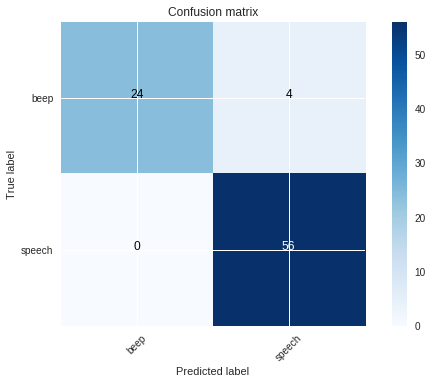

In [30]:
cm = metrics.confusion_matrix(y_test, rf)

plot_confusion_matrix(cm, class_names)

In [0]:
import pickle
pickle.dump(model, open("rf-mfccs_40-10s-2.pkl", "wb"))

from google.colab import files

with open('example.txt', 'w') as f:
  f.write('some content')

files.download('rf-mfccs_40-10s-2.pkl')

In [0]:
X_train[0].shape

(40,)

In [0]:
df = df.copy().sample(1)
df.mfccs_40.shape
model.predict(df.mfccs_40)

ValueError: ignored

# XGBoost

In [0]:
import xgboost as xgb

model = xgb.XGBClassifier()
model.fit(X_train, y_train)
xgb = model.predict(X_test)
print_classification_results(y_test, xgb)

0.927710843373494
              precision    recall  f1-score   support

           0       0.96      0.82      0.88        28
           1       0.92      0.98      0.95        55

   micro avg       0.93      0.93      0.93        83
   macro avg       0.94      0.90      0.92        83
weighted avg       0.93      0.93      0.93        83

[[23  5]
 [ 1 54]]



# LogisticRegression

In [0]:
# create the RFE model and select 3 best attributes
from sklearn.feature_selection import RFE
rfe = RFE(model, 3)
rfe = rfe.fit(X_train, y_train)
logReg = rfe.predict(X_test)
print_classification_results(y_test, logReg)

0.8291139240506329
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        31
           1       0.00      0.00      0.00        25
           2       0.80      1.00      0.89       102

   micro avg       0.83      0.83      0.83       158
   macro avg       0.58      0.65      0.61       158
weighted avg       0.70      0.83      0.76       158

[[ 29   0   2]
 [  2   0  23]
 [  0   0 102]]



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# SVM

In [0]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}

Grid scores on development set:

0.909 (+/-0.059) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.923 (+/-0.038) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.911 (+/-0.051) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.917 (+/-0.055) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.911 (+/-0.051) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.890 (+/-0.052) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.911 (+/-0.051) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.890 (+/-0.052) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.917 (+/-0.092) for {'C': 1, 'kernel': 'linear'}
0.917 (+/-0.092) for {'C': 10, 'kernel': 'linear'}
0.917 (+/-0.092) for {'C': 100, 'kernel': 'linear'}
0.917 (+/-0.092) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
from sklearn import svm

# {}
model = svm.SVC(C=1, kernel='linear')
model.fit(X_train, y_train)
svm = model.predict(X_test)
print_classification_results(y_test, svm)

0.8795180722891566
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        28
           1       0.91      0.91      0.91        55

   micro avg       0.88      0.88      0.88        83
   macro avg       0.87      0.87      0.87        83
weighted avg       0.88      0.88      0.88        83

[[23  5]
 [ 5 50]]



# Keras

In [0]:
features_to_include = ['mfccs','chroma','mel','contrast','tonnetz']
X, y = generateFeaturesLabels(features_to_include)

from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline


def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(2, input_dim=281, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model. We use the the logarithmic loss function, and the Adam gradient optimizer.
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
  

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X, y, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

KeyboardInterrupt: ignored

In [0]:
len(X)

TypeError: ignored

In [0]:
X

<tf.Tensor 'Placeholder:0' shape=(?, 281) dtype=float32>

In [14]:
le.classes

AttributeError: ignored